# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [67]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

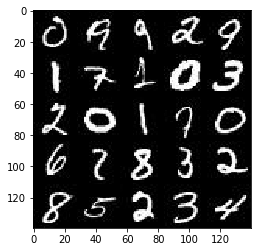

In [68]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

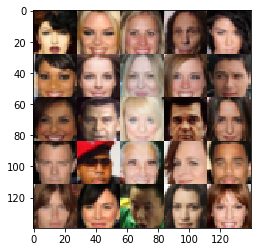

In [69]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [70]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [71]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [72]:
# additional functions

# for debugging - print out the tensor shapes
def tensor_shape(t):
    print('shape: ' + str(t.shape))

# switch for using leaky relu or not
def relu_type(leaky, alpha, t):
        if leaky == 1:
            a = tf.maximum(alpha * t, t)
        else:
            a = tf.nn.relu(t)
        return a
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    
    # define sizes - from 28 > 14 > 7 > 4 
    size = 64
    sz_1, sz_2, sz_3 = size*1, size*4, size*16
    
    use_leaky_relu = 1 # switch to use either (1==yes, 0==No)
    
    with tf.variable_scope('discriminator', reuse=reuse) as discrim_scope:
        # create conv net with input images that are 28 x 28 x 3 (channel for the face data)
        # tf.layers.dense([input_image], filter depth, kernel size, strides, padding)
        disc_1 = tf.layers.conv2d(images, sz_1, 5, strides=2, padding='same')
        relu_1 = relu_type(use_leaky_relu, alpha, disc_1)
        # relu_1 = tf.layers.dropout(relu_1, keep_prob)
        # output size: 14 x 14 x 64
        
        disc_2 = tf.layers.conv2d(relu_1, sz_2, 5, strides=2, padding='same')
        bn_2 = tf.layers.batch_normalization(disc_2, training=True)
        relu_2 = relu_type(use_leaky_relu, alpha, bn_2)
        # relu_2 = tf.layers.dropout(relu_2, keep_prob)
        # output size: 7 x 7 x 256
        
        disc_3 = tf.layers.conv2d(relu_2, sz_3, 5, strides=2, padding='same')
        bn_3 = tf.layers.batch_normalization(disc_3, training=True)
        relu_3 = relu_type(use_leaky_relu, alpha, bn_3)
        # output size: 4 x 4 x 1024
        
        # flatten the shape
        flat = tf.reshape(relu_3, (-1, 2*2*sz_3))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        # bebug - print shapes
#         tensor_shape(images)
#         tensor_shape(relu_1)
#         tensor_shape(relu_2)
#         tensor_shape(relu_3)
#         tensor_shape(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [73]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    use_leaky_relu = 1 # switch to use either (1==yes, 0==No)
    
    size = 64
    sz_1, sz_2, sz_3 = size*1, size*4, size*16
    
    reuse = not is_train # need to set this value from something
    training = is_train # keeps is similar to the lessons to avoid confusion
    
    with tf.variable_scope('generator', reuse=reuse) as gen_scope:
        # this must be the reverse of the discriminator
        gen_1 = tf.layers.dense(z, 4 * 4 * sz_3)
        # reshapre to start conv transpose stack
        gen_1 = tf.reshape(gen_1, (-1, 4, 4, sz_3))
        gen_1 = tf.layers.batch_normalization(gen_1, training=training)
        gen_1 = relu_type(use_leaky_relu, alpha, gen_1)
        # output shape: 4 x 4 x 1024
        
        gen_2 = tf.layers.conv2d_transpose(gen_1, sz_2, 4, strides=1, padding='valid')
        gen_2 = tf.layers.batch_normalization(gen_2, training=training)
        gen_2 = relu_type(use_leaky_relu, alpha, gen_2)
        # output shape: 7 x 7 x 256
        
        gen_3 = tf.layers.conv2d_transpose(gen_2, sz_1, 4, strides=2, padding='same')
        gen_3 = tf.layers.batch_normalization(gen_3, training=training)
        gen_3 = relu_type(use_leaky_relu, alpha, gen_3)
        # output size: 14 x 14 x 64  
        
        # output layer
        logits = tf.layers.conv2d_transpose(gen_3, out_channel_dim, 4, strides=2, padding='same')
        # output size: 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
        
        # bebug - print shapes
#         tensor_shape(z)
#         tensor_shape(gen_1)
#         tensor_shape(gen_2)
#         tensor_shape(gen_3)
#         tensor_shape(logits)
#         print(out_channel_dim)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [74]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth_param = 0.1 # smoothing parameter
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * (1-smooth_param)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                        labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                        labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [75]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('disc')]
    g_vars = [v for v in t_vars if v.name.startswith('gen')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [77]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # vars needed 
    # samples, losses = [], []
    losses = []
    count_itters = 0 # to count itterations
    print_every = 10 # print state every itterations
    show_every = 100 # show state every itterations
    fig_size = (5, 5)
    
    # keep var names here the same as the reutrns from the functions for sanity
    # inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # start the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # count iterations
                count_itters += 1
                
                # batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                # Sample random noise for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # batch_z = batch_z.reshape(batch_size, z_dim)
                
                # run optimizers
                # discriminator
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                                     lr: learning_rate})
                # generator
                for g_runs in range(2):
                    _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                                         lr: learning_rate})
                
                
                if count_itters % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses for review after training
                    losses.append((train_loss_d, train_loss_g))
                
                if (count_itters % show_every == 0) or count_itters == 1:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                    
    # plot losses 
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

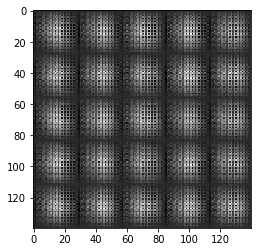

Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 1.5350
Epoch 1/2... Discriminator Loss: 2.7443... Generator Loss: 0.1936
Epoch 1/2... Discriminator Loss: 2.0336... Generator Loss: 0.3774
Epoch 1/2... Discriminator Loss: 1.6107... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 1.8000
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 1.1561
Epoch 1/2... Discriminator Loss: 1.8163... Generator Loss: 1.7409
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 1.8404
Epoch 1/2... Discriminator Loss: 1.7558... Generator Loss: 1.3305
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 0.9222


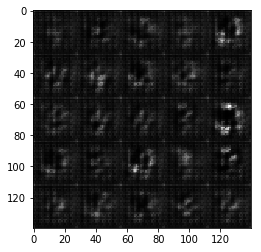

Epoch 1/2... Discriminator Loss: 1.6056... Generator Loss: 1.9606
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.4876
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.6036... Generator Loss: 0.4049


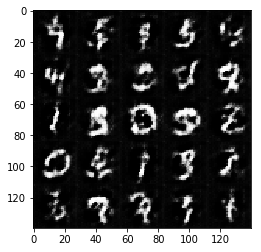

Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.5065... Generator Loss: 1.4045
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 1.3353
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 1.2545
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 1.3457
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.8747


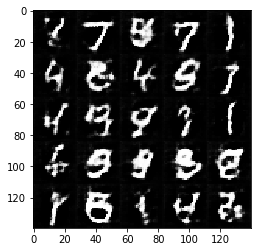

Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 1.2972
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.5387... Generator Loss: 0.4675
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 1.5377... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.8194
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.8373
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.8674


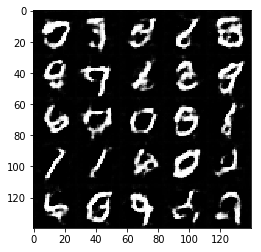

Epoch 1/2... Discriminator Loss: 1.7178... Generator Loss: 1.4071
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 1.2299
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 1.0518
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.8737
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 1.5474... Generator Loss: 1.2374
Epoch 2/2... Discriminator Loss: 1.5018... Generator Loss: 1.3559


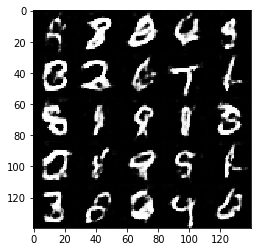

Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 1.9560... Generator Loss: 1.7882
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.8318
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.3785... Generator Loss: 1.0961
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 1.1665


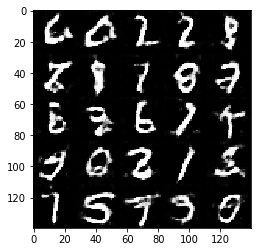

Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 1.4761... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 1.5402... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 1.7256... Generator Loss: 0.3492
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 2.0532... Generator Loss: 2.0101
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.6737... Generator Loss: 0.4133
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.7682


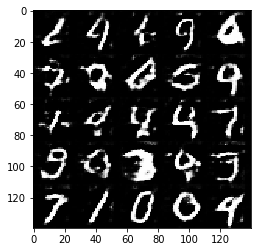

Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 1.5110... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 1.5660... Generator Loss: 0.4182
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.6208
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.6403... Generator Loss: 1.2319


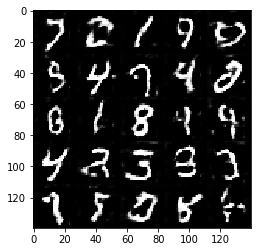

Epoch 2/2... Discriminator Loss: 1.3785... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.5390... Generator Loss: 1.2540
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.4065... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.9265
Epoch 2/2... Discriminator Loss: 1.4430... Generator Loss: 1.3250
Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 1.5472... Generator Loss: 1.3938
Epoch 2/2... Discriminator Loss: 1.4045... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 1.5182... Generator Loss: 0.4471


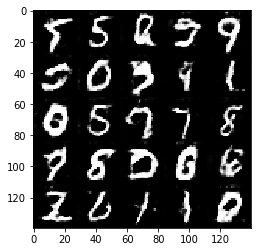

Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.8251
Epoch 2/2... Discriminator Loss: 1.7273... Generator Loss: 1.6699
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7134


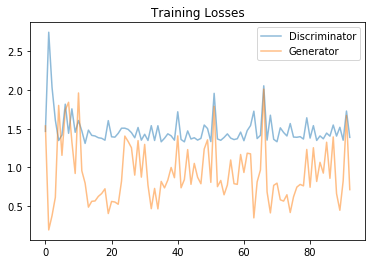

In [78]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

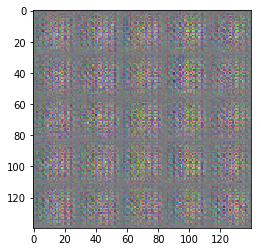

Epoch 1/4... Discriminator Loss: 2.0959... Generator Loss: 10.4060
Epoch 1/4... Discriminator Loss: 2.5235... Generator Loss: 1.6161
Epoch 1/4... Discriminator Loss: 1.1905... Generator Loss: 5.0129
Epoch 1/4... Discriminator Loss: 1.0511... Generator Loss: 2.6311
Epoch 1/4... Discriminator Loss: 1.2198... Generator Loss: 1.6932
Epoch 1/4... Discriminator Loss: 1.6105... Generator Loss: 0.6549
Epoch 1/4... Discriminator Loss: 1.4973... Generator Loss: 0.9752
Epoch 1/4... Discriminator Loss: 1.7924... Generator Loss: 1.3683
Epoch 1/4... Discriminator Loss: 1.4306... Generator Loss: 0.6868
Epoch 1/4... Discriminator Loss: 1.4635... Generator Loss: 0.6654


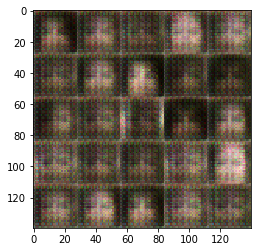

Epoch 1/4... Discriminator Loss: 1.5464... Generator Loss: 0.8574
Epoch 1/4... Discriminator Loss: 1.2874... Generator Loss: 1.1985
Epoch 1/4... Discriminator Loss: 1.4999... Generator Loss: 1.0376
Epoch 1/4... Discriminator Loss: 1.5093... Generator Loss: 0.6311
Epoch 1/4... Discriminator Loss: 1.4980... Generator Loss: 0.5365
Epoch 1/4... Discriminator Loss: 1.2985... Generator Loss: 0.8838
Epoch 1/4... Discriminator Loss: 1.5634... Generator Loss: 0.5763
Epoch 1/4... Discriminator Loss: 1.4057... Generator Loss: 0.6732
Epoch 1/4... Discriminator Loss: 1.4301... Generator Loss: 0.6796
Epoch 1/4... Discriminator Loss: 1.3373... Generator Loss: 0.9981


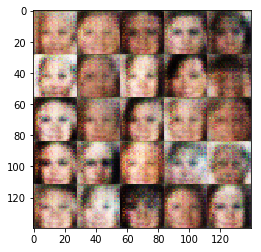

Epoch 1/4... Discriminator Loss: 1.4621... Generator Loss: 0.7845
Epoch 1/4... Discriminator Loss: 1.4302... Generator Loss: 0.7120
Epoch 1/4... Discriminator Loss: 1.3935... Generator Loss: 0.7387
Epoch 1/4... Discriminator Loss: 1.4543... Generator Loss: 0.6867
Epoch 1/4... Discriminator Loss: 1.5438... Generator Loss: 0.8508
Epoch 1/4... Discriminator Loss: 1.3728... Generator Loss: 0.9320
Epoch 1/4... Discriminator Loss: 1.4323... Generator Loss: 0.7600
Epoch 1/4... Discriminator Loss: 1.5003... Generator Loss: 0.7708
Epoch 1/4... Discriminator Loss: 1.4888... Generator Loss: 0.8497
Epoch 1/4... Discriminator Loss: 1.3920... Generator Loss: 0.8143


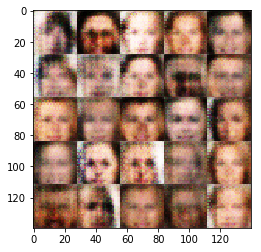

Epoch 1/4... Discriminator Loss: 1.3772... Generator Loss: 0.8586
Epoch 1/4... Discriminator Loss: 1.3755... Generator Loss: 0.8310
Epoch 1/4... Discriminator Loss: 1.4765... Generator Loss: 0.7788
Epoch 1/4... Discriminator Loss: 1.4029... Generator Loss: 0.7573
Epoch 1/4... Discriminator Loss: 1.4221... Generator Loss: 0.8029
Epoch 1/4... Discriminator Loss: 1.4229... Generator Loss: 0.8121
Epoch 1/4... Discriminator Loss: 1.3493... Generator Loss: 0.7700
Epoch 1/4... Discriminator Loss: 1.4366... Generator Loss: 0.8286
Epoch 1/4... Discriminator Loss: 1.4175... Generator Loss: 0.8037
Epoch 1/4... Discriminator Loss: 1.4674... Generator Loss: 0.8036


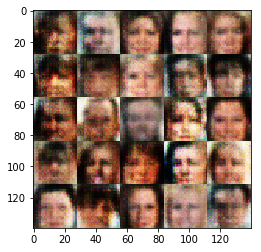

Epoch 1/4... Discriminator Loss: 1.4320... Generator Loss: 0.6695
Epoch 1/4... Discriminator Loss: 1.4061... Generator Loss: 0.7709
Epoch 1/4... Discriminator Loss: 1.3992... Generator Loss: 0.6907
Epoch 1/4... Discriminator Loss: 1.3513... Generator Loss: 0.9358
Epoch 1/4... Discriminator Loss: 1.3979... Generator Loss: 0.7568
Epoch 1/4... Discriminator Loss: 1.4087... Generator Loss: 0.9017
Epoch 1/4... Discriminator Loss: 1.4126... Generator Loss: 0.7216
Epoch 1/4... Discriminator Loss: 1.3665... Generator Loss: 0.8947
Epoch 1/4... Discriminator Loss: 1.4344... Generator Loss: 0.7327
Epoch 1/4... Discriminator Loss: 1.4033... Generator Loss: 0.9211


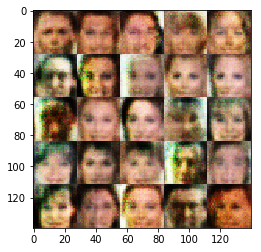

Epoch 1/4... Discriminator Loss: 1.4191... Generator Loss: 0.8311
Epoch 1/4... Discriminator Loss: 1.4061... Generator Loss: 0.7386
Epoch 1/4... Discriminator Loss: 1.4389... Generator Loss: 0.7990
Epoch 1/4... Discriminator Loss: 1.4176... Generator Loss: 0.7874
Epoch 1/4... Discriminator Loss: 1.3977... Generator Loss: 0.6990
Epoch 1/4... Discriminator Loss: 1.3870... Generator Loss: 0.8171
Epoch 1/4... Discriminator Loss: 1.4289... Generator Loss: 0.7074
Epoch 1/4... Discriminator Loss: 1.3870... Generator Loss: 0.7985
Epoch 1/4... Discriminator Loss: 1.4385... Generator Loss: 0.8063
Epoch 1/4... Discriminator Loss: 1.3650... Generator Loss: 0.8159


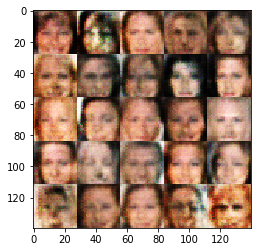

Epoch 1/4... Discriminator Loss: 1.3846... Generator Loss: 0.7801
Epoch 1/4... Discriminator Loss: 1.3624... Generator Loss: 0.8292
Epoch 1/4... Discriminator Loss: 1.4081... Generator Loss: 0.8328
Epoch 1/4... Discriminator Loss: 1.4047... Generator Loss: 0.7220
Epoch 1/4... Discriminator Loss: 1.4366... Generator Loss: 0.7295
Epoch 1/4... Discriminator Loss: 1.3544... Generator Loss: 0.8243
Epoch 1/4... Discriminator Loss: 1.4018... Generator Loss: 0.8448
Epoch 1/4... Discriminator Loss: 1.4373... Generator Loss: 0.7810
Epoch 1/4... Discriminator Loss: 1.4389... Generator Loss: 0.8229
Epoch 1/4... Discriminator Loss: 1.4300... Generator Loss: 0.7560


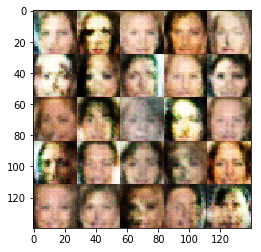

Epoch 1/4... Discriminator Loss: 1.3567... Generator Loss: 0.8779
Epoch 1/4... Discriminator Loss: 1.3724... Generator Loss: 0.7689
Epoch 1/4... Discriminator Loss: 1.4087... Generator Loss: 0.8074
Epoch 1/4... Discriminator Loss: 1.4080... Generator Loss: 0.7364
Epoch 1/4... Discriminator Loss: 1.3865... Generator Loss: 0.8034
Epoch 1/4... Discriminator Loss: 1.3957... Generator Loss: 0.8139
Epoch 1/4... Discriminator Loss: 1.4315... Generator Loss: 0.7721
Epoch 1/4... Discriminator Loss: 1.4146... Generator Loss: 0.7727
Epoch 1/4... Discriminator Loss: 1.3832... Generator Loss: 0.8739
Epoch 1/4... Discriminator Loss: 1.3859... Generator Loss: 0.8441


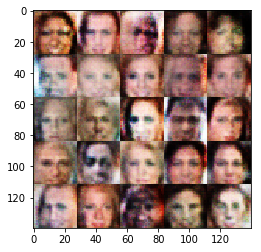

Epoch 1/4... Discriminator Loss: 1.4011... Generator Loss: 0.7808
Epoch 1/4... Discriminator Loss: 1.3570... Generator Loss: 0.8654
Epoch 1/4... Discriminator Loss: 1.4293... Generator Loss: 0.7970
Epoch 1/4... Discriminator Loss: 1.3897... Generator Loss: 0.7763
Epoch 1/4... Discriminator Loss: 1.4488... Generator Loss: 0.7802
Epoch 1/4... Discriminator Loss: 1.4110... Generator Loss: 0.7726
Epoch 1/4... Discriminator Loss: 1.4319... Generator Loss: 0.8357
Epoch 1/4... Discriminator Loss: 1.4234... Generator Loss: 0.6830
Epoch 1/4... Discriminator Loss: 1.3735... Generator Loss: 0.8014
Epoch 1/4... Discriminator Loss: 1.3600... Generator Loss: 0.7568


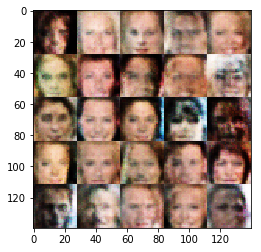

Epoch 1/4... Discriminator Loss: 1.3988... Generator Loss: 0.9245
Epoch 1/4... Discriminator Loss: 1.3823... Generator Loss: 0.8412
Epoch 1/4... Discriminator Loss: 1.3939... Generator Loss: 0.7437
Epoch 1/4... Discriminator Loss: 1.3865... Generator Loss: 0.7812
Epoch 1/4... Discriminator Loss: 1.3554... Generator Loss: 0.8250
Epoch 1/4... Discriminator Loss: 1.3983... Generator Loss: 0.8329
Epoch 1/4... Discriminator Loss: 1.3704... Generator Loss: 0.8325
Epoch 1/4... Discriminator Loss: 1.3321... Generator Loss: 0.7871
Epoch 1/4... Discriminator Loss: 1.4083... Generator Loss: 0.8295
Epoch 1/4... Discriminator Loss: 1.3999... Generator Loss: 0.8072


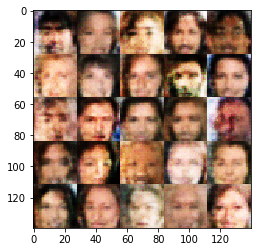

Epoch 1/4... Discriminator Loss: 1.3856... Generator Loss: 0.8645
Epoch 1/4... Discriminator Loss: 1.4318... Generator Loss: 0.7946
Epoch 1/4... Discriminator Loss: 1.3990... Generator Loss: 0.7492
Epoch 1/4... Discriminator Loss: 1.4104... Generator Loss: 0.7416
Epoch 1/4... Discriminator Loss: 1.4064... Generator Loss: 0.7720
Epoch 1/4... Discriminator Loss: 1.3730... Generator Loss: 0.8253
Epoch 1/4... Discriminator Loss: 1.4063... Generator Loss: 0.8286
Epoch 1/4... Discriminator Loss: 1.3817... Generator Loss: 0.7390
Epoch 1/4... Discriminator Loss: 1.3957... Generator Loss: 0.7711
Epoch 1/4... Discriminator Loss: 1.4148... Generator Loss: 0.7319


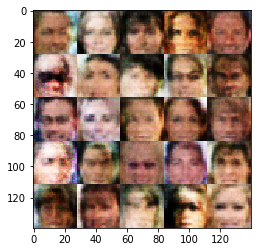

Epoch 1/4... Discriminator Loss: 1.3417... Generator Loss: 0.8096
Epoch 1/4... Discriminator Loss: 1.3686... Generator Loss: 0.7801
Epoch 1/4... Discriminator Loss: 1.4636... Generator Loss: 0.7528
Epoch 1/4... Discriminator Loss: 1.3798... Generator Loss: 0.7646
Epoch 1/4... Discriminator Loss: 1.4388... Generator Loss: 0.6872
Epoch 1/4... Discriminator Loss: 1.4132... Generator Loss: 0.8509
Epoch 1/4... Discriminator Loss: 1.4033... Generator Loss: 0.7180
Epoch 1/4... Discriminator Loss: 1.3894... Generator Loss: 0.7709
Epoch 1/4... Discriminator Loss: 1.4007... Generator Loss: 0.8084
Epoch 1/4... Discriminator Loss: 1.3980... Generator Loss: 0.8178


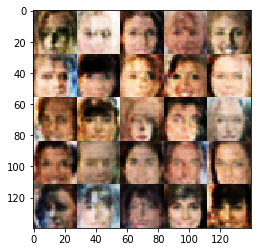

Epoch 1/4... Discriminator Loss: 1.4142... Generator Loss: 0.8314
Epoch 1/4... Discriminator Loss: 1.3789... Generator Loss: 0.7511
Epoch 1/4... Discriminator Loss: 1.3807... Generator Loss: 0.7382
Epoch 1/4... Discriminator Loss: 1.3760... Generator Loss: 0.8703
Epoch 1/4... Discriminator Loss: 1.4178... Generator Loss: 0.8674
Epoch 1/4... Discriminator Loss: 1.3703... Generator Loss: 0.7672
Epoch 1/4... Discriminator Loss: 1.3758... Generator Loss: 0.7783
Epoch 1/4... Discriminator Loss: 1.3902... Generator Loss: 0.7898
Epoch 1/4... Discriminator Loss: 1.3964... Generator Loss: 0.7100
Epoch 1/4... Discriminator Loss: 1.4015... Generator Loss: 0.7198


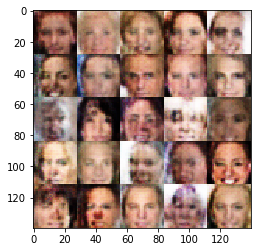

Epoch 1/4... Discriminator Loss: 1.3995... Generator Loss: 0.7376
Epoch 1/4... Discriminator Loss: 1.3930... Generator Loss: 0.6740
Epoch 1/4... Discriminator Loss: 1.4162... Generator Loss: 0.8211
Epoch 1/4... Discriminator Loss: 1.4102... Generator Loss: 0.8174
Epoch 1/4... Discriminator Loss: 1.3608... Generator Loss: 0.8234
Epoch 1/4... Discriminator Loss: 1.3908... Generator Loss: 0.7718
Epoch 1/4... Discriminator Loss: 1.3931... Generator Loss: 0.7738
Epoch 1/4... Discriminator Loss: 1.4380... Generator Loss: 0.7874
Epoch 1/4... Discriminator Loss: 1.3789... Generator Loss: 0.7691
Epoch 1/4... Discriminator Loss: 1.4146... Generator Loss: 0.7053


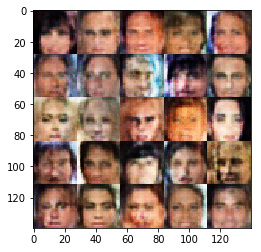

Epoch 1/4... Discriminator Loss: 1.4166... Generator Loss: 0.7008
Epoch 1/4... Discriminator Loss: 1.4093... Generator Loss: 0.6750
Epoch 1/4... Discriminator Loss: 1.4000... Generator Loss: 0.8215
Epoch 1/4... Discriminator Loss: 1.3242... Generator Loss: 0.9381
Epoch 1/4... Discriminator Loss: 1.3945... Generator Loss: 0.8003
Epoch 1/4... Discriminator Loss: 1.3489... Generator Loss: 0.8460
Epoch 1/4... Discriminator Loss: 1.4346... Generator Loss: 0.7203
Epoch 1/4... Discriminator Loss: 1.3624... Generator Loss: 0.8232
Epoch 1/4... Discriminator Loss: 1.4003... Generator Loss: 0.8762
Epoch 1/4... Discriminator Loss: 1.3874... Generator Loss: 0.8057


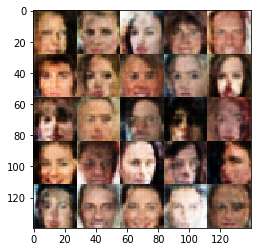

Epoch 1/4... Discriminator Loss: 1.3672... Generator Loss: 0.7561
Epoch 1/4... Discriminator Loss: 1.3866... Generator Loss: 0.6945
Epoch 1/4... Discriminator Loss: 1.3877... Generator Loss: 0.7892
Epoch 1/4... Discriminator Loss: 1.4342... Generator Loss: 0.8147
Epoch 1/4... Discriminator Loss: 1.3829... Generator Loss: 0.8019
Epoch 1/4... Discriminator Loss: 1.3967... Generator Loss: 0.8373
Epoch 1/4... Discriminator Loss: 1.3951... Generator Loss: 0.8222
Epoch 1/4... Discriminator Loss: 1.3958... Generator Loss: 0.7039
Epoch 2/4... Discriminator Loss: 1.5736... Generator Loss: 0.6239
Epoch 2/4... Discriminator Loss: 1.3688... Generator Loss: 0.8572


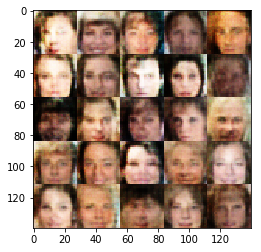

Epoch 2/4... Discriminator Loss: 1.3807... Generator Loss: 0.7433
Epoch 2/4... Discriminator Loss: 1.3934... Generator Loss: 0.7247
Epoch 2/4... Discriminator Loss: 1.3541... Generator Loss: 0.8208
Epoch 2/4... Discriminator Loss: 1.4123... Generator Loss: 0.8173
Epoch 2/4... Discriminator Loss: 1.3764... Generator Loss: 0.7952
Epoch 2/4... Discriminator Loss: 1.4159... Generator Loss: 0.7484
Epoch 2/4... Discriminator Loss: 1.4090... Generator Loss: 0.7636
Epoch 2/4... Discriminator Loss: 1.4078... Generator Loss: 0.7564
Epoch 2/4... Discriminator Loss: 1.4044... Generator Loss: 0.8320
Epoch 2/4... Discriminator Loss: 1.4200... Generator Loss: 0.7698


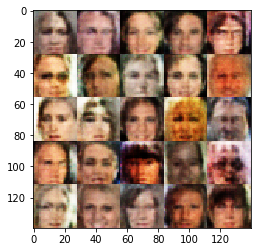

Epoch 2/4... Discriminator Loss: 1.3991... Generator Loss: 0.7896
Epoch 2/4... Discriminator Loss: 1.3740... Generator Loss: 0.7848
Epoch 2/4... Discriminator Loss: 1.4034... Generator Loss: 0.7429
Epoch 2/4... Discriminator Loss: 1.4308... Generator Loss: 0.6802
Epoch 2/4... Discriminator Loss: 1.3698... Generator Loss: 0.8362
Epoch 2/4... Discriminator Loss: 1.3854... Generator Loss: 0.7791
Epoch 2/4... Discriminator Loss: 1.3690... Generator Loss: 0.7772
Epoch 2/4... Discriminator Loss: 1.4318... Generator Loss: 0.9793
Epoch 2/4... Discriminator Loss: 1.4972... Generator Loss: 0.6888
Epoch 2/4... Discriminator Loss: 1.4144... Generator Loss: 0.7247


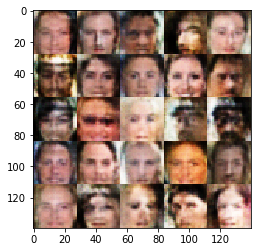

Epoch 2/4... Discriminator Loss: 1.4544... Generator Loss: 0.7136
Epoch 2/4... Discriminator Loss: 1.3526... Generator Loss: 0.7532
Epoch 2/4... Discriminator Loss: 1.4014... Generator Loss: 0.7421
Epoch 2/4... Discriminator Loss: 1.3652... Generator Loss: 0.7399
Epoch 2/4... Discriminator Loss: 1.3850... Generator Loss: 0.8044
Epoch 2/4... Discriminator Loss: 1.3951... Generator Loss: 0.7505
Epoch 2/4... Discriminator Loss: 1.4355... Generator Loss: 0.6997
Epoch 2/4... Discriminator Loss: 1.4113... Generator Loss: 0.7512
Epoch 2/4... Discriminator Loss: 1.4319... Generator Loss: 0.8210
Epoch 2/4... Discriminator Loss: 1.4196... Generator Loss: 0.7433


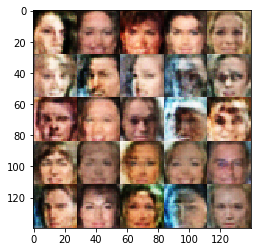

Epoch 2/4... Discriminator Loss: 1.3866... Generator Loss: 0.7544
Epoch 2/4... Discriminator Loss: 1.3985... Generator Loss: 0.7555
Epoch 2/4... Discriminator Loss: 1.3905... Generator Loss: 0.8042
Epoch 2/4... Discriminator Loss: 1.4106... Generator Loss: 0.7852
Epoch 2/4... Discriminator Loss: 1.4043... Generator Loss: 0.7251
Epoch 2/4... Discriminator Loss: 1.3833... Generator Loss: 0.7661
Epoch 2/4... Discriminator Loss: 1.4026... Generator Loss: 0.6996
Epoch 2/4... Discriminator Loss: 1.4161... Generator Loss: 0.6898
Epoch 2/4... Discriminator Loss: 1.3882... Generator Loss: 0.7217
Epoch 2/4... Discriminator Loss: 1.4045... Generator Loss: 0.7304


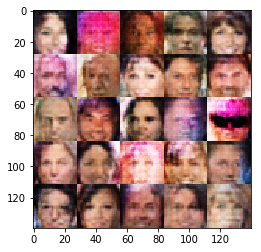

Epoch 2/4... Discriminator Loss: 1.4305... Generator Loss: 0.7398
Epoch 2/4... Discriminator Loss: 1.4485... Generator Loss: 0.7687
Epoch 2/4... Discriminator Loss: 1.3922... Generator Loss: 0.8278
Epoch 2/4... Discriminator Loss: 1.3917... Generator Loss: 0.7426
Epoch 2/4... Discriminator Loss: 1.3553... Generator Loss: 0.7783
Epoch 2/4... Discriminator Loss: 1.3624... Generator Loss: 0.7956
Epoch 2/4... Discriminator Loss: 1.4307... Generator Loss: 0.7377
Epoch 2/4... Discriminator Loss: 1.4339... Generator Loss: 0.5899
Epoch 2/4... Discriminator Loss: 1.4128... Generator Loss: 0.6544
Epoch 2/4... Discriminator Loss: 1.3686... Generator Loss: 0.8061


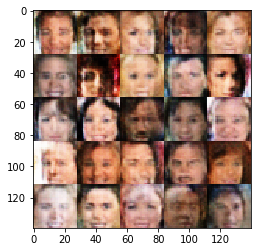

Epoch 2/4... Discriminator Loss: 1.4715... Generator Loss: 0.7118
Epoch 2/4... Discriminator Loss: 1.3953... Generator Loss: 0.7277
Epoch 2/4... Discriminator Loss: 1.4014... Generator Loss: 0.7320
Epoch 2/4... Discriminator Loss: 1.3780... Generator Loss: 0.7600
Epoch 2/4... Discriminator Loss: 1.3868... Generator Loss: 0.7135
Epoch 2/4... Discriminator Loss: 1.4367... Generator Loss: 0.8145
Epoch 2/4... Discriminator Loss: 1.3552... Generator Loss: 0.8288
Epoch 2/4... Discriminator Loss: 1.4065... Generator Loss: 0.7107
Epoch 2/4... Discriminator Loss: 1.3929... Generator Loss: 0.7429
Epoch 2/4... Discriminator Loss: 1.4372... Generator Loss: 0.7533


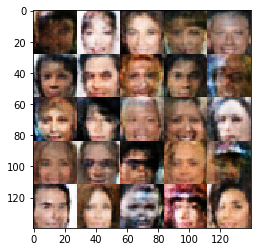

Epoch 2/4... Discriminator Loss: 1.4082... Generator Loss: 0.7650
Epoch 2/4... Discriminator Loss: 1.4137... Generator Loss: 0.8686
Epoch 2/4... Discriminator Loss: 1.3859... Generator Loss: 0.7538
Epoch 2/4... Discriminator Loss: 1.3932... Generator Loss: 0.7684
Epoch 2/4... Discriminator Loss: 1.3709... Generator Loss: 0.8465
Epoch 2/4... Discriminator Loss: 1.3954... Generator Loss: 0.7283
Epoch 2/4... Discriminator Loss: 1.4295... Generator Loss: 0.7479
Epoch 2/4... Discriminator Loss: 1.4534... Generator Loss: 0.7250
Epoch 2/4... Discriminator Loss: 1.3891... Generator Loss: 0.7649
Epoch 2/4... Discriminator Loss: 1.4260... Generator Loss: 0.8470


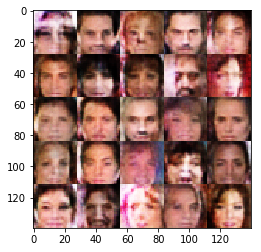

Epoch 2/4... Discriminator Loss: 1.3969... Generator Loss: 0.7584
Epoch 2/4... Discriminator Loss: 1.3768... Generator Loss: 0.7835
Epoch 2/4... Discriminator Loss: 1.3854... Generator Loss: 0.7633
Epoch 2/4... Discriminator Loss: 1.3882... Generator Loss: 0.8189
Epoch 2/4... Discriminator Loss: 1.4332... Generator Loss: 0.8537
Epoch 2/4... Discriminator Loss: 1.3896... Generator Loss: 0.8138
Epoch 2/4... Discriminator Loss: 1.3950... Generator Loss: 0.7725
Epoch 2/4... Discriminator Loss: 1.3963... Generator Loss: 0.7202
Epoch 2/4... Discriminator Loss: 1.3770... Generator Loss: 0.7609
Epoch 2/4... Discriminator Loss: 1.3850... Generator Loss: 0.7863


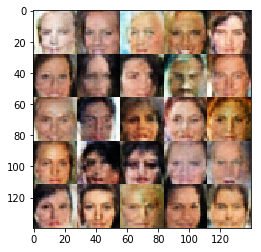

Epoch 2/4... Discriminator Loss: 1.4047... Generator Loss: 0.7315
Epoch 2/4... Discriminator Loss: 1.4195... Generator Loss: 0.6959
Epoch 2/4... Discriminator Loss: 1.3872... Generator Loss: 0.7370
Epoch 2/4... Discriminator Loss: 1.3931... Generator Loss: 0.7820
Epoch 2/4... Discriminator Loss: 1.3900... Generator Loss: 0.7209
Epoch 2/4... Discriminator Loss: 1.4120... Generator Loss: 0.7589
Epoch 2/4... Discriminator Loss: 1.4162... Generator Loss: 0.6798
Epoch 2/4... Discriminator Loss: 1.3950... Generator Loss: 0.7946
Epoch 2/4... Discriminator Loss: 1.3675... Generator Loss: 0.8171
Epoch 2/4... Discriminator Loss: 1.3954... Generator Loss: 0.7268


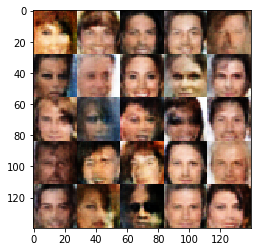

Epoch 2/4... Discriminator Loss: 1.4061... Generator Loss: 0.7460
Epoch 2/4... Discriminator Loss: 1.4363... Generator Loss: 0.7302
Epoch 2/4... Discriminator Loss: 1.4412... Generator Loss: 0.8175
Epoch 2/4... Discriminator Loss: 1.4123... Generator Loss: 0.8660
Epoch 2/4... Discriminator Loss: 1.4271... Generator Loss: 0.6975
Epoch 2/4... Discriminator Loss: 1.3996... Generator Loss: 0.7595
Epoch 2/4... Discriminator Loss: 1.4130... Generator Loss: 0.7991
Epoch 2/4... Discriminator Loss: 1.4214... Generator Loss: 0.8340
Epoch 2/4... Discriminator Loss: 1.3967... Generator Loss: 0.7760
Epoch 2/4... Discriminator Loss: 1.3371... Generator Loss: 0.7525


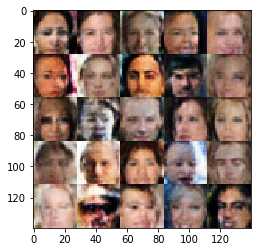

Epoch 2/4... Discriminator Loss: 1.4035... Generator Loss: 0.6207
Epoch 2/4... Discriminator Loss: 1.4160... Generator Loss: 0.7680
Epoch 2/4... Discriminator Loss: 1.3800... Generator Loss: 0.7620
Epoch 2/4... Discriminator Loss: 1.4182... Generator Loss: 0.7403
Epoch 2/4... Discriminator Loss: 1.4154... Generator Loss: 0.6793
Epoch 2/4... Discriminator Loss: 1.4104... Generator Loss: 0.6829
Epoch 2/4... Discriminator Loss: 1.4278... Generator Loss: 0.7408
Epoch 2/4... Discriminator Loss: 1.3956... Generator Loss: 0.7271
Epoch 2/4... Discriminator Loss: 1.4270... Generator Loss: 0.7495
Epoch 2/4... Discriminator Loss: 1.4160... Generator Loss: 0.7061


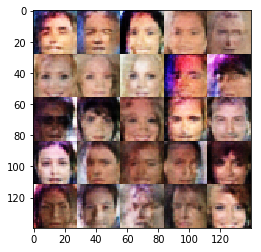

Epoch 2/4... Discriminator Loss: 1.3930... Generator Loss: 0.7758
Epoch 2/4... Discriminator Loss: 1.4241... Generator Loss: 0.6992
Epoch 2/4... Discriminator Loss: 1.3853... Generator Loss: 0.8066
Epoch 2/4... Discriminator Loss: 1.4115... Generator Loss: 0.8052
Epoch 2/4... Discriminator Loss: 1.4204... Generator Loss: 0.6724
Epoch 2/4... Discriminator Loss: 1.3452... Generator Loss: 0.8022
Epoch 2/4... Discriminator Loss: 1.4092... Generator Loss: 0.7228
Epoch 2/4... Discriminator Loss: 1.3806... Generator Loss: 0.8098
Epoch 2/4... Discriminator Loss: 1.3691... Generator Loss: 0.7474
Epoch 2/4... Discriminator Loss: 1.4185... Generator Loss: 0.8650


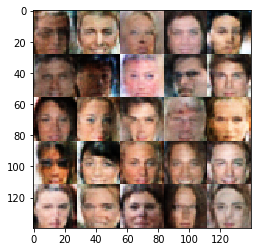

Epoch 2/4... Discriminator Loss: 1.3854... Generator Loss: 0.8021
Epoch 2/4... Discriminator Loss: 1.3296... Generator Loss: 0.7533
Epoch 2/4... Discriminator Loss: 1.4090... Generator Loss: 0.7936
Epoch 2/4... Discriminator Loss: 1.3673... Generator Loss: 0.7704
Epoch 2/4... Discriminator Loss: 1.3757... Generator Loss: 0.8534
Epoch 2/4... Discriminator Loss: 1.4128... Generator Loss: 0.7665
Epoch 2/4... Discriminator Loss: 1.3585... Generator Loss: 0.7548
Epoch 2/4... Discriminator Loss: 1.4113... Generator Loss: 0.6833
Epoch 2/4... Discriminator Loss: 1.3926... Generator Loss: 0.7534
Epoch 2/4... Discriminator Loss: 1.4319... Generator Loss: 0.7296


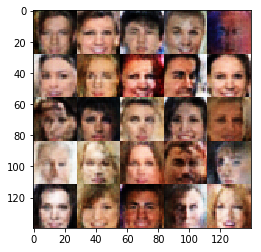

Epoch 2/4... Discriminator Loss: 1.4217... Generator Loss: 0.7065
Epoch 2/4... Discriminator Loss: 1.3412... Generator Loss: 0.8191
Epoch 2/4... Discriminator Loss: 1.4052... Generator Loss: 0.8281
Epoch 2/4... Discriminator Loss: 1.4100... Generator Loss: 0.6667
Epoch 2/4... Discriminator Loss: 1.4205... Generator Loss: 0.7335
Epoch 2/4... Discriminator Loss: 1.3665... Generator Loss: 0.8349
Epoch 2/4... Discriminator Loss: 1.4126... Generator Loss: 0.8816
Epoch 2/4... Discriminator Loss: 1.4036... Generator Loss: 0.6974
Epoch 2/4... Discriminator Loss: 1.4231... Generator Loss: 0.7073
Epoch 2/4... Discriminator Loss: 1.3810... Generator Loss: 0.7471


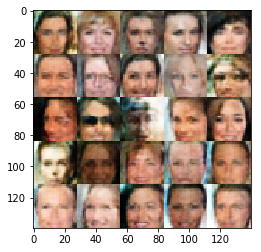

Epoch 2/4... Discriminator Loss: 1.4189... Generator Loss: 0.7452
Epoch 2/4... Discriminator Loss: 1.3997... Generator Loss: 0.8093
Epoch 2/4... Discriminator Loss: 1.3714... Generator Loss: 0.8140
Epoch 2/4... Discriminator Loss: 1.3966... Generator Loss: 0.7786
Epoch 2/4... Discriminator Loss: 1.4087... Generator Loss: 0.8584
Epoch 2/4... Discriminator Loss: 1.4041... Generator Loss: 0.7876
Epoch 2/4... Discriminator Loss: 1.4049... Generator Loss: 0.8054
Epoch 2/4... Discriminator Loss: 1.4044... Generator Loss: 0.7809
Epoch 2/4... Discriminator Loss: 1.4161... Generator Loss: 0.7405
Epoch 2/4... Discriminator Loss: 1.4220... Generator Loss: 0.6271


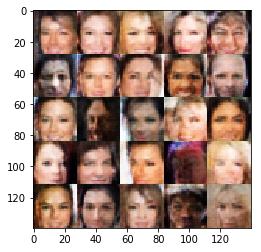

Epoch 2/4... Discriminator Loss: 1.4074... Generator Loss: 0.7808
Epoch 2/4... Discriminator Loss: 1.4097... Generator Loss: 0.7320
Epoch 2/4... Discriminator Loss: 1.3942... Generator Loss: 0.7289
Epoch 2/4... Discriminator Loss: 1.4198... Generator Loss: 0.7999
Epoch 2/4... Discriminator Loss: 1.4018... Generator Loss: 0.7958
Epoch 2/4... Discriminator Loss: 1.4423... Generator Loss: 0.7327
Epoch 3/4... Discriminator Loss: 1.4181... Generator Loss: 0.6633
Epoch 3/4... Discriminator Loss: 1.4279... Generator Loss: 0.7845
Epoch 3/4... Discriminator Loss: 1.4031... Generator Loss: 0.8542
Epoch 3/4... Discriminator Loss: 1.4032... Generator Loss: 0.8825


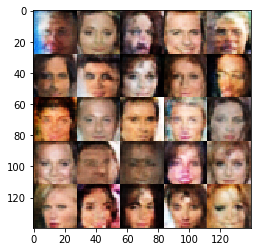

Epoch 3/4... Discriminator Loss: 1.4198... Generator Loss: 0.7870
Epoch 3/4... Discriminator Loss: 1.4201... Generator Loss: 0.6651
Epoch 3/4... Discriminator Loss: 1.3951... Generator Loss: 0.9232
Epoch 3/4... Discriminator Loss: 1.3681... Generator Loss: 0.7922
Epoch 3/4... Discriminator Loss: 1.4205... Generator Loss: 0.7670
Epoch 3/4... Discriminator Loss: 1.3753... Generator Loss: 0.8291
Epoch 3/4... Discriminator Loss: 1.3821... Generator Loss: 0.8032
Epoch 3/4... Discriminator Loss: 1.4037... Generator Loss: 0.7051
Epoch 3/4... Discriminator Loss: 1.3963... Generator Loss: 0.7207
Epoch 3/4... Discriminator Loss: 1.4218... Generator Loss: 0.6586


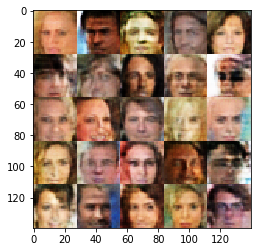

Epoch 3/4... Discriminator Loss: 1.4149... Generator Loss: 0.8722
Epoch 3/4... Discriminator Loss: 1.4712... Generator Loss: 0.6584
Epoch 3/4... Discriminator Loss: 1.3939... Generator Loss: 0.8308
Epoch 3/4... Discriminator Loss: 1.4310... Generator Loss: 0.7860
Epoch 3/4... Discriminator Loss: 1.4126... Generator Loss: 0.7918
Epoch 3/4... Discriminator Loss: 1.4463... Generator Loss: 0.6094
Epoch 3/4... Discriminator Loss: 1.4412... Generator Loss: 0.6417
Epoch 3/4... Discriminator Loss: 1.3957... Generator Loss: 0.6948
Epoch 3/4... Discriminator Loss: 1.4347... Generator Loss: 0.7526
Epoch 3/4... Discriminator Loss: 1.4598... Generator Loss: 0.6727


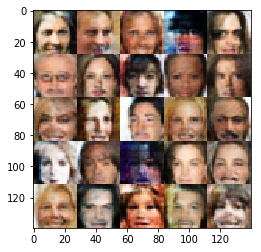

Epoch 3/4... Discriminator Loss: 1.3815... Generator Loss: 0.8249
Epoch 3/4... Discriminator Loss: 1.4123... Generator Loss: 0.7180
Epoch 3/4... Discriminator Loss: 1.4069... Generator Loss: 0.7831
Epoch 3/4... Discriminator Loss: 1.4165... Generator Loss: 0.7229
Epoch 3/4... Discriminator Loss: 1.3865... Generator Loss: 0.8140
Epoch 3/4... Discriminator Loss: 1.4326... Generator Loss: 0.7393
Epoch 3/4... Discriminator Loss: 1.3908... Generator Loss: 0.7202
Epoch 3/4... Discriminator Loss: 1.4187... Generator Loss: 0.6904
Epoch 3/4... Discriminator Loss: 1.3856... Generator Loss: 0.7921
Epoch 3/4... Discriminator Loss: 1.4612... Generator Loss: 0.6300


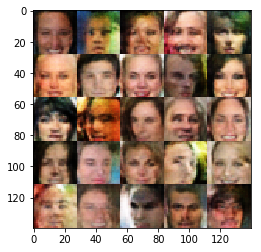

Epoch 3/4... Discriminator Loss: 1.3553... Generator Loss: 0.8852
Epoch 3/4... Discriminator Loss: 1.4494... Generator Loss: 0.7110
Epoch 3/4... Discriminator Loss: 1.3924... Generator Loss: 0.7369
Epoch 3/4... Discriminator Loss: 1.3414... Generator Loss: 0.8322
Epoch 3/4... Discriminator Loss: 1.3826... Generator Loss: 0.7479
Epoch 3/4... Discriminator Loss: 1.4182... Generator Loss: 0.6738
Epoch 3/4... Discriminator Loss: 1.3681... Generator Loss: 0.7173
Epoch 3/4... Discriminator Loss: 1.4333... Generator Loss: 0.6603
Epoch 3/4... Discriminator Loss: 1.4562... Generator Loss: 0.6596
Epoch 3/4... Discriminator Loss: 1.3505... Generator Loss: 0.7575


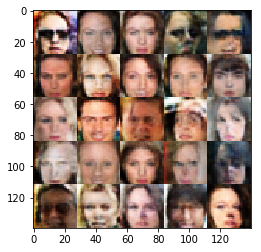

Epoch 3/4... Discriminator Loss: 1.4496... Generator Loss: 0.8102
Epoch 3/4... Discriminator Loss: 1.3882... Generator Loss: 0.7570
Epoch 3/4... Discriminator Loss: 1.5033... Generator Loss: 0.8503
Epoch 3/4... Discriminator Loss: 1.3958... Generator Loss: 0.7926
Epoch 3/4... Discriminator Loss: 1.4229... Generator Loss: 0.6338
Epoch 3/4... Discriminator Loss: 1.4046... Generator Loss: 0.6914
Epoch 3/4... Discriminator Loss: 1.4178... Generator Loss: 0.7082
Epoch 3/4... Discriminator Loss: 1.4239... Generator Loss: 0.6872
Epoch 3/4... Discriminator Loss: 1.4296... Generator Loss: 0.6492
Epoch 3/4... Discriminator Loss: 1.4781... Generator Loss: 0.9121


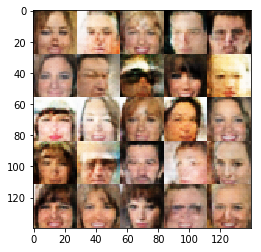

Epoch 3/4... Discriminator Loss: 1.5263... Generator Loss: 0.6483
Epoch 3/4... Discriminator Loss: 1.3925... Generator Loss: 0.7950
Epoch 3/4... Discriminator Loss: 1.3872... Generator Loss: 0.7279
Epoch 3/4... Discriminator Loss: 1.3552... Generator Loss: 0.7825
Epoch 3/4... Discriminator Loss: 1.3713... Generator Loss: 0.7469
Epoch 3/4... Discriminator Loss: 1.4066... Generator Loss: 0.7342
Epoch 3/4... Discriminator Loss: 1.4221... Generator Loss: 0.6786
Epoch 3/4... Discriminator Loss: 1.4079... Generator Loss: 0.7415
Epoch 3/4... Discriminator Loss: 1.4184... Generator Loss: 0.6807
Epoch 3/4... Discriminator Loss: 1.4222... Generator Loss: 0.7420


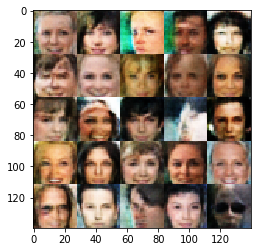

Epoch 3/4... Discriminator Loss: 1.4300... Generator Loss: 0.6383
Epoch 3/4... Discriminator Loss: 1.3684... Generator Loss: 0.8033
Epoch 3/4... Discriminator Loss: 1.4003... Generator Loss: 0.7682
Epoch 3/4... Discriminator Loss: 1.4361... Generator Loss: 0.6741
Epoch 3/4... Discriminator Loss: 1.3661... Generator Loss: 0.8734
Epoch 3/4... Discriminator Loss: 1.3884... Generator Loss: 0.7609
Epoch 3/4... Discriminator Loss: 1.4063... Generator Loss: 0.6730
Epoch 3/4... Discriminator Loss: 1.4529... Generator Loss: 0.6433
Epoch 3/4... Discriminator Loss: 1.3539... Generator Loss: 0.7686
Epoch 3/4... Discriminator Loss: 1.4597... Generator Loss: 0.7742


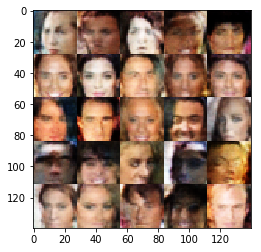

Epoch 3/4... Discriminator Loss: 1.3638... Generator Loss: 0.7365
Epoch 3/4... Discriminator Loss: 1.4004... Generator Loss: 0.7250
Epoch 3/4... Discriminator Loss: 1.3712... Generator Loss: 0.9066
Epoch 3/4... Discriminator Loss: 1.3729... Generator Loss: 0.8511
Epoch 3/4... Discriminator Loss: 1.3833... Generator Loss: 0.6786
Epoch 3/4... Discriminator Loss: 1.3612... Generator Loss: 0.9243
Epoch 3/4... Discriminator Loss: 1.4099... Generator Loss: 0.7461
Epoch 3/4... Discriminator Loss: 1.3685... Generator Loss: 0.7151
Epoch 3/4... Discriminator Loss: 1.3989... Generator Loss: 0.6781
Epoch 3/4... Discriminator Loss: 1.4666... Generator Loss: 0.6008


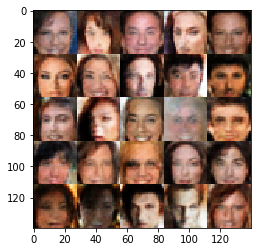

Epoch 3/4... Discriminator Loss: 1.4189... Generator Loss: 0.7059
Epoch 3/4... Discriminator Loss: 1.4350... Generator Loss: 0.7815
Epoch 3/4... Discriminator Loss: 1.4068... Generator Loss: 0.7009
Epoch 3/4... Discriminator Loss: 1.4482... Generator Loss: 0.6426
Epoch 3/4... Discriminator Loss: 1.4445... Generator Loss: 0.6083
Epoch 3/4... Discriminator Loss: 1.3918... Generator Loss: 0.7291
Epoch 3/4... Discriminator Loss: 1.4049... Generator Loss: 0.8223
Epoch 3/4... Discriminator Loss: 1.3989... Generator Loss: 0.7646
Epoch 3/4... Discriminator Loss: 1.5224... Generator Loss: 1.0386
Epoch 3/4... Discriminator Loss: 1.5643... Generator Loss: 0.8128


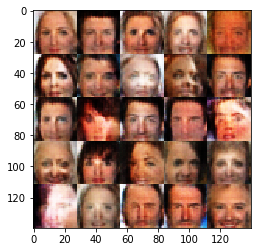

Epoch 3/4... Discriminator Loss: 1.3833... Generator Loss: 0.8180
Epoch 3/4... Discriminator Loss: 1.3541... Generator Loss: 0.8198
Epoch 3/4... Discriminator Loss: 1.3622... Generator Loss: 0.7904
Epoch 3/4... Discriminator Loss: 1.3775... Generator Loss: 0.7783
Epoch 3/4... Discriminator Loss: 1.3798... Generator Loss: 0.7971
Epoch 3/4... Discriminator Loss: 1.3819... Generator Loss: 0.7793
Epoch 3/4... Discriminator Loss: 1.3822... Generator Loss: 0.7768
Epoch 3/4... Discriminator Loss: 1.3685... Generator Loss: 0.7550
Epoch 3/4... Discriminator Loss: 1.3725... Generator Loss: 0.7790
Epoch 3/4... Discriminator Loss: 1.3694... Generator Loss: 0.7553


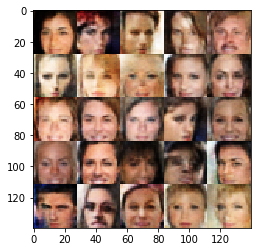

Epoch 3/4... Discriminator Loss: 1.3512... Generator Loss: 0.7411
Epoch 3/4... Discriminator Loss: 1.3651... Generator Loss: 0.7510
Epoch 3/4... Discriminator Loss: 1.3657... Generator Loss: 0.7518
Epoch 3/4... Discriminator Loss: 1.4209... Generator Loss: 0.7072
Epoch 3/4... Discriminator Loss: 1.3845... Generator Loss: 0.7395
Epoch 3/4... Discriminator Loss: 1.4061... Generator Loss: 0.7111
Epoch 3/4... Discriminator Loss: 1.4159... Generator Loss: 0.7306
Epoch 3/4... Discriminator Loss: 1.3604... Generator Loss: 0.7881
Epoch 3/4... Discriminator Loss: 1.4066... Generator Loss: 0.7299
Epoch 3/4... Discriminator Loss: 1.4168... Generator Loss: 0.7302


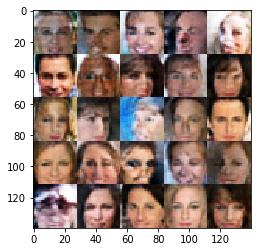

Epoch 3/4... Discriminator Loss: 1.3636... Generator Loss: 0.7395
Epoch 3/4... Discriminator Loss: 1.3911... Generator Loss: 0.7871
Epoch 3/4... Discriminator Loss: 1.4128... Generator Loss: 0.7059
Epoch 3/4... Discriminator Loss: 1.3846... Generator Loss: 0.6399
Epoch 3/4... Discriminator Loss: 1.4099... Generator Loss: 0.9421
Epoch 3/4... Discriminator Loss: 1.3864... Generator Loss: 0.7658
Epoch 3/4... Discriminator Loss: 1.3812... Generator Loss: 0.7003
Epoch 3/4... Discriminator Loss: 1.3384... Generator Loss: 0.7767
Epoch 3/4... Discriminator Loss: 1.3701... Generator Loss: 0.8121
Epoch 3/4... Discriminator Loss: 1.4183... Generator Loss: 0.7358


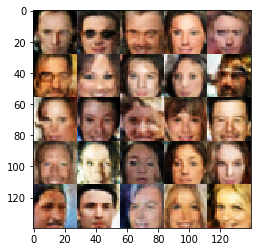

Epoch 3/4... Discriminator Loss: 1.4077... Generator Loss: 0.7516
Epoch 3/4... Discriminator Loss: 1.3779... Generator Loss: 0.7095
Epoch 3/4... Discriminator Loss: 1.4709... Generator Loss: 0.5911
Epoch 3/4... Discriminator Loss: 1.4024... Generator Loss: 0.7267
Epoch 3/4... Discriminator Loss: 1.3965... Generator Loss: 0.7388
Epoch 3/4... Discriminator Loss: 1.3616... Generator Loss: 0.7708
Epoch 3/4... Discriminator Loss: 1.3738... Generator Loss: 0.8044
Epoch 3/4... Discriminator Loss: 1.4181... Generator Loss: 0.7585
Epoch 3/4... Discriminator Loss: 1.4315... Generator Loss: 0.6890
Epoch 3/4... Discriminator Loss: 1.4739... Generator Loss: 0.6129


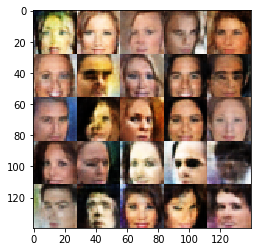

Epoch 3/4... Discriminator Loss: 1.4022... Generator Loss: 0.7437
Epoch 3/4... Discriminator Loss: 1.3684... Generator Loss: 0.7388
Epoch 3/4... Discriminator Loss: 1.3925... Generator Loss: 0.6943
Epoch 3/4... Discriminator Loss: 1.4472... Generator Loss: 0.6476
Epoch 3/4... Discriminator Loss: 1.3753... Generator Loss: 0.9083
Epoch 3/4... Discriminator Loss: 1.3971... Generator Loss: 0.6947
Epoch 3/4... Discriminator Loss: 1.4223... Generator Loss: 0.7930
Epoch 3/4... Discriminator Loss: 1.4181... Generator Loss: 0.8411
Epoch 3/4... Discriminator Loss: 1.4092... Generator Loss: 0.7071
Epoch 3/4... Discriminator Loss: 1.4027... Generator Loss: 0.7409


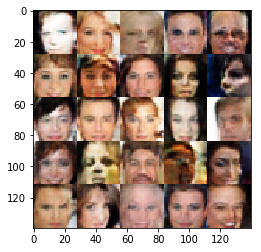

Epoch 3/4... Discriminator Loss: 1.4128... Generator Loss: 0.6550
Epoch 3/4... Discriminator Loss: 1.4415... Generator Loss: 0.6333
Epoch 3/4... Discriminator Loss: 1.4291... Generator Loss: 0.6526
Epoch 3/4... Discriminator Loss: 1.4760... Generator Loss: 0.5896
Epoch 3/4... Discriminator Loss: 1.4181... Generator Loss: 0.7978
Epoch 3/4... Discriminator Loss: 1.4334... Generator Loss: 0.7107
Epoch 3/4... Discriminator Loss: 1.4867... Generator Loss: 0.6005
Epoch 3/4... Discriminator Loss: 1.4273... Generator Loss: 0.6393
Epoch 3/4... Discriminator Loss: 1.3402... Generator Loss: 0.7078
Epoch 3/4... Discriminator Loss: 1.3787... Generator Loss: 0.8315


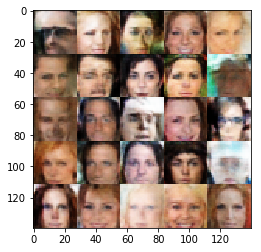

Epoch 3/4... Discriminator Loss: 1.3929... Generator Loss: 0.9608
Epoch 3/4... Discriminator Loss: 1.4184... Generator Loss: 0.7565
Epoch 3/4... Discriminator Loss: 1.4833... Generator Loss: 0.7696
Epoch 3/4... Discriminator Loss: 1.3819... Generator Loss: 0.7075
Epoch 4/4... Discriminator Loss: 1.3703... Generator Loss: 0.7353
Epoch 4/4... Discriminator Loss: 1.3982... Generator Loss: 0.8298
Epoch 4/4... Discriminator Loss: 1.4415... Generator Loss: 0.7292
Epoch 4/4... Discriminator Loss: 1.4418... Generator Loss: 1.0206
Epoch 4/4... Discriminator Loss: 1.4000... Generator Loss: 0.7686
Epoch 4/4... Discriminator Loss: 1.4179... Generator Loss: 0.7303


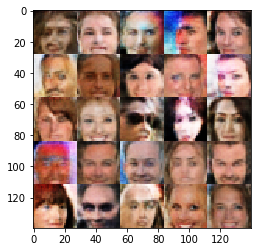

Epoch 4/4... Discriminator Loss: 1.4686... Generator Loss: 0.5988
Epoch 4/4... Discriminator Loss: 1.4060... Generator Loss: 0.7543
Epoch 4/4... Discriminator Loss: 1.4862... Generator Loss: 0.8928
Epoch 4/4... Discriminator Loss: 1.3924... Generator Loss: 0.6483
Epoch 4/4... Discriminator Loss: 1.3802... Generator Loss: 0.8392
Epoch 4/4... Discriminator Loss: 1.4201... Generator Loss: 0.7335
Epoch 4/4... Discriminator Loss: 1.4045... Generator Loss: 0.7228
Epoch 4/4... Discriminator Loss: 1.5413... Generator Loss: 1.0351
Epoch 4/4... Discriminator Loss: 1.3780... Generator Loss: 0.7606
Epoch 4/4... Discriminator Loss: 1.3485... Generator Loss: 0.7809


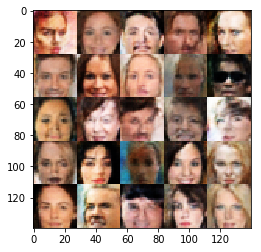

Epoch 4/4... Discriminator Loss: 1.3899... Generator Loss: 0.8701
Epoch 4/4... Discriminator Loss: 1.4137... Generator Loss: 0.6341
Epoch 4/4... Discriminator Loss: 1.3918... Generator Loss: 0.7024
Epoch 4/4... Discriminator Loss: 1.3701... Generator Loss: 0.6964
Epoch 4/4... Discriminator Loss: 1.3867... Generator Loss: 0.6402
Epoch 4/4... Discriminator Loss: 1.4380... Generator Loss: 0.6571
Epoch 4/4... Discriminator Loss: 1.3879... Generator Loss: 0.7264
Epoch 4/4... Discriminator Loss: 1.4355... Generator Loss: 0.6060
Epoch 4/4... Discriminator Loss: 1.4012... Generator Loss: 0.8461
Epoch 4/4... Discriminator Loss: 1.4180... Generator Loss: 0.9001


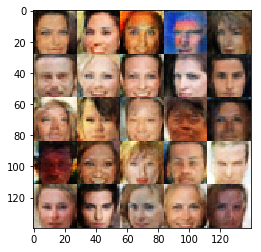

Epoch 4/4... Discriminator Loss: 1.4080... Generator Loss: 0.7462
Epoch 4/4... Discriminator Loss: 1.3871... Generator Loss: 0.7150
Epoch 4/4... Discriminator Loss: 1.3308... Generator Loss: 0.7871
Epoch 4/4... Discriminator Loss: 1.4311... Generator Loss: 0.6122
Epoch 4/4... Discriminator Loss: 1.4779... Generator Loss: 0.5534
Epoch 4/4... Discriminator Loss: 1.3742... Generator Loss: 0.7217
Epoch 4/4... Discriminator Loss: 1.3892... Generator Loss: 0.6521
Epoch 4/4... Discriminator Loss: 1.4544... Generator Loss: 0.6617
Epoch 4/4... Discriminator Loss: 1.4214... Generator Loss: 1.0129
Epoch 4/4... Discriminator Loss: 1.4116... Generator Loss: 0.6865


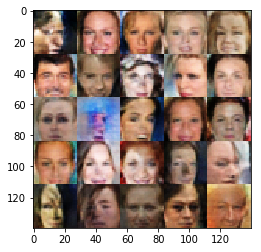

Epoch 4/4... Discriminator Loss: 1.4031... Generator Loss: 0.6901
Epoch 4/4... Discriminator Loss: 1.3805... Generator Loss: 0.6763
Epoch 4/4... Discriminator Loss: 1.4655... Generator Loss: 0.6247
Epoch 4/4... Discriminator Loss: 1.4008... Generator Loss: 0.6716
Epoch 4/4... Discriminator Loss: 1.3745... Generator Loss: 0.7932
Epoch 4/4... Discriminator Loss: 1.3557... Generator Loss: 0.7729
Epoch 4/4... Discriminator Loss: 1.5013... Generator Loss: 0.5566
Epoch 4/4... Discriminator Loss: 1.3735... Generator Loss: 0.7159
Epoch 4/4... Discriminator Loss: 1.4231... Generator Loss: 0.7831
Epoch 4/4... Discriminator Loss: 1.3972... Generator Loss: 0.7122


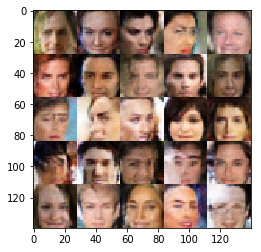

Epoch 4/4... Discriminator Loss: 1.3452... Generator Loss: 0.9667
Epoch 4/4... Discriminator Loss: 1.4831... Generator Loss: 0.5989
Epoch 4/4... Discriminator Loss: 1.3612... Generator Loss: 0.8215
Epoch 4/4... Discriminator Loss: 1.5201... Generator Loss: 0.5934
Epoch 4/4... Discriminator Loss: 1.3430... Generator Loss: 0.7518
Epoch 4/4... Discriminator Loss: 1.4304... Generator Loss: 0.6972
Epoch 4/4... Discriminator Loss: 1.4748... Generator Loss: 0.5710
Epoch 4/4... Discriminator Loss: 1.4733... Generator Loss: 0.5483
Epoch 4/4... Discriminator Loss: 1.4029... Generator Loss: 0.7310
Epoch 4/4... Discriminator Loss: 1.4164... Generator Loss: 0.6782


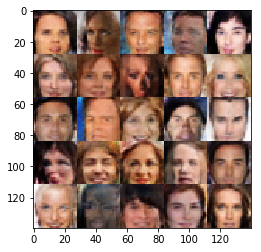

Epoch 4/4... Discriminator Loss: 1.3808... Generator Loss: 0.6994
Epoch 4/4... Discriminator Loss: 1.3982... Generator Loss: 0.6953
Epoch 4/4... Discriminator Loss: 1.4120... Generator Loss: 0.8334
Epoch 4/4... Discriminator Loss: 1.3942... Generator Loss: 0.7251
Epoch 4/4... Discriminator Loss: 1.4327... Generator Loss: 0.7252
Epoch 4/4... Discriminator Loss: 1.3903... Generator Loss: 0.6397
Epoch 4/4... Discriminator Loss: 1.3962... Generator Loss: 0.6952
Epoch 4/4... Discriminator Loss: 1.3099... Generator Loss: 0.8634
Epoch 4/4... Discriminator Loss: 1.4379... Generator Loss: 0.6431
Epoch 4/4... Discriminator Loss: 1.4315... Generator Loss: 0.5970


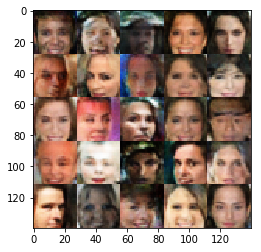

Epoch 4/4... Discriminator Loss: 1.4422... Generator Loss: 0.6108
Epoch 4/4... Discriminator Loss: 2.6097... Generator Loss: 1.8110
Epoch 4/4... Discriminator Loss: 1.3781... Generator Loss: 0.8512
Epoch 4/4... Discriminator Loss: 1.3843... Generator Loss: 0.7806
Epoch 4/4... Discriminator Loss: 1.3608... Generator Loss: 0.7644
Epoch 4/4... Discriminator Loss: 1.3755... Generator Loss: 0.7151
Epoch 4/4... Discriminator Loss: 1.4072... Generator Loss: 0.7061
Epoch 4/4... Discriminator Loss: 1.3300... Generator Loss: 0.7492
Epoch 4/4... Discriminator Loss: 1.3656... Generator Loss: 0.7241
Epoch 4/4... Discriminator Loss: 1.3699... Generator Loss: 0.6917


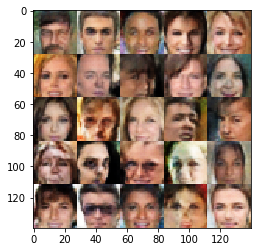

Epoch 4/4... Discriminator Loss: 1.2921... Generator Loss: 0.8566
Epoch 4/4... Discriminator Loss: 1.3777... Generator Loss: 0.6903
Epoch 4/4... Discriminator Loss: 1.4248... Generator Loss: 0.7011
Epoch 4/4... Discriminator Loss: 1.4323... Generator Loss: 0.6400
Epoch 4/4... Discriminator Loss: 1.3934... Generator Loss: 0.7744
Epoch 4/4... Discriminator Loss: 1.3903... Generator Loss: 0.7500
Epoch 4/4... Discriminator Loss: 1.3872... Generator Loss: 0.7958
Epoch 4/4... Discriminator Loss: 1.3842... Generator Loss: 0.6393
Epoch 4/4... Discriminator Loss: 1.3847... Generator Loss: 0.7355
Epoch 4/4... Discriminator Loss: 1.3923... Generator Loss: 0.6040


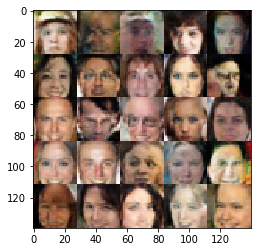

Epoch 4/4... Discriminator Loss: 1.5079... Generator Loss: 0.6961
Epoch 4/4... Discriminator Loss: 1.3947... Generator Loss: 0.7852
Epoch 4/4... Discriminator Loss: 1.4326... Generator Loss: 0.6951
Epoch 4/4... Discriminator Loss: 1.3633... Generator Loss: 0.7636
Epoch 4/4... Discriminator Loss: 1.6114... Generator Loss: 0.6254
Epoch 4/4... Discriminator Loss: 1.4202... Generator Loss: 0.6681
Epoch 4/4... Discriminator Loss: 1.4525... Generator Loss: 0.5741
Epoch 4/4... Discriminator Loss: 3.0951... Generator Loss: 1.1373
Epoch 4/4... Discriminator Loss: 1.6325... Generator Loss: 0.8328
Epoch 4/4... Discriminator Loss: 1.3690... Generator Loss: 0.8345


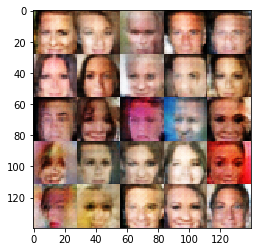

Epoch 4/4... Discriminator Loss: 1.4262... Generator Loss: 0.7456
Epoch 4/4... Discriminator Loss: 1.3810... Generator Loss: 0.7656
Epoch 4/4... Discriminator Loss: 1.3830... Generator Loss: 0.7889
Epoch 4/4... Discriminator Loss: 1.4170... Generator Loss: 0.7820
Epoch 4/4... Discriminator Loss: 1.3919... Generator Loss: 0.7873
Epoch 4/4... Discriminator Loss: 1.3842... Generator Loss: 0.7999
Epoch 4/4... Discriminator Loss: 1.3747... Generator Loss: 0.7977
Epoch 4/4... Discriminator Loss: 1.3988... Generator Loss: 0.7967
Epoch 4/4... Discriminator Loss: 1.3937... Generator Loss: 0.7959
Epoch 4/4... Discriminator Loss: 1.3835... Generator Loss: 0.7936


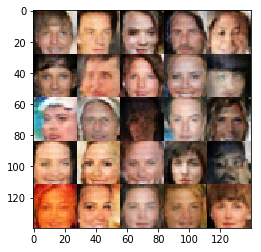

Epoch 4/4... Discriminator Loss: 1.3649... Generator Loss: 0.7864
Epoch 4/4... Discriminator Loss: 1.3612... Generator Loss: 0.8018
Epoch 4/4... Discriminator Loss: 1.3748... Generator Loss: 0.7826
Epoch 4/4... Discriminator Loss: 1.3888... Generator Loss: 0.7623
Epoch 4/4... Discriminator Loss: 1.3471... Generator Loss: 0.7757
Epoch 4/4... Discriminator Loss: 1.3552... Generator Loss: 0.7391
Epoch 4/4... Discriminator Loss: 1.3597... Generator Loss: 0.7274
Epoch 4/4... Discriminator Loss: 1.3947... Generator Loss: 0.7425
Epoch 4/4... Discriminator Loss: 1.3855... Generator Loss: 0.6842
Epoch 4/4... Discriminator Loss: 1.3734... Generator Loss: 0.7406


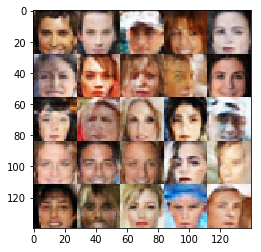

Epoch 4/4... Discriminator Loss: 1.3841... Generator Loss: 0.6629
Epoch 4/4... Discriminator Loss: 1.4691... Generator Loss: 0.6234
Epoch 4/4... Discriminator Loss: 1.4283... Generator Loss: 0.6379
Epoch 4/4... Discriminator Loss: 1.3862... Generator Loss: 0.7836
Epoch 4/4... Discriminator Loss: 1.4299... Generator Loss: 0.6508
Epoch 4/4... Discriminator Loss: 1.3615... Generator Loss: 0.7504
Epoch 4/4... Discriminator Loss: 1.4181... Generator Loss: 1.0118
Epoch 4/4... Discriminator Loss: 1.3646... Generator Loss: 0.7213
Epoch 4/4... Discriminator Loss: 1.3729... Generator Loss: 0.6949
Epoch 4/4... Discriminator Loss: 1.4026... Generator Loss: 0.6548


Epoch 4/4... Discriminator Loss: 1.4076... Generator Loss: 0.8551
Epoch 4/4... Discriminator Loss: 1.3467... Generator Loss: 0.8771
Epoch 4/4... Discriminator Loss: 1.3393... Generator Loss: 0.9380
Epoch 4/4... Discriminator Loss: 1.3617... Generator Loss: 0.6483
Epoch 4/4... Discriminator Loss: 1.4632... Generator Loss: 0.5600
Epoch 4/4... Discriminator Loss: 1.3586... Generator Loss: 0.6682
Epoch 4/4... Discriminator Loss: 1.4741... Generator Loss: 0.5263
Epoch 4/4... Discriminator Loss: 1.3352... Generator Loss: 0.7257
Epoch 4/4... Discriminator Loss: 1.3664... Generator Loss: 0.7583
Epoch 4/4... Discriminator Loss: 1.4691... Generator Loss: 0.7735


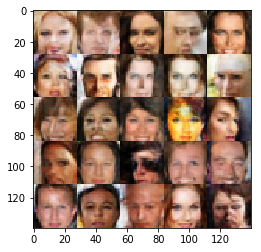

Epoch 4/4... Discriminator Loss: 1.4091... Generator Loss: 0.7634
Epoch 4/4... Discriminator Loss: 1.4257... Generator Loss: 0.5989
Epoch 4/4... Discriminator Loss: 1.3652... Generator Loss: 0.6486
Epoch 4/4... Discriminator Loss: 1.4344... Generator Loss: 0.6738
Epoch 4/4... Discriminator Loss: 1.3633... Generator Loss: 0.7046
Epoch 4/4... Discriminator Loss: 1.4267... Generator Loss: 0.6658
Epoch 4/4... Discriminator Loss: 1.3916... Generator Loss: 0.8222
Epoch 4/4... Discriminator Loss: 1.4145... Generator Loss: 0.9768
Epoch 4/4... Discriminator Loss: 1.3831... Generator Loss: 0.7582
Epoch 4/4... Discriminator Loss: 1.3582... Generator Loss: 0.7132


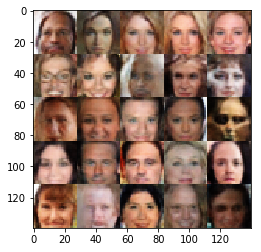

Epoch 4/4... Discriminator Loss: 1.3544... Generator Loss: 0.7960
Epoch 4/4... Discriminator Loss: 1.4549... Generator Loss: 0.6650
Epoch 4/4... Discriminator Loss: 1.3251... Generator Loss: 0.7141
Epoch 4/4... Discriminator Loss: 1.3490... Generator Loss: 0.8724
Epoch 4/4... Discriminator Loss: 1.4778... Generator Loss: 0.6337
Epoch 4/4... Discriminator Loss: 1.3513... Generator Loss: 0.7532
Epoch 4/4... Discriminator Loss: 1.5043... Generator Loss: 0.6581
Epoch 4/4... Discriminator Loss: 1.3292... Generator Loss: 0.8608
Epoch 4/4... Discriminator Loss: 1.3687... Generator Loss: 0.8195
Epoch 4/4... Discriminator Loss: 1.3471... Generator Loss: 0.7878


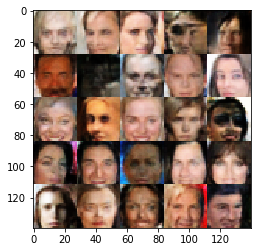

Epoch 4/4... Discriminator Loss: 1.3203... Generator Loss: 0.6678
Epoch 4/4... Discriminator Loss: 1.3919... Generator Loss: 0.6299


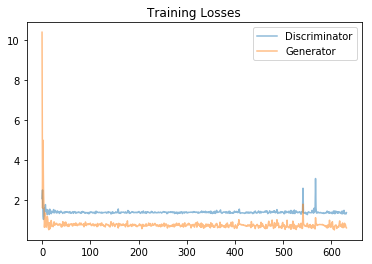

In [80]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.